<a href="https://colab.research.google.com/github/EJH22/MSc-TranslationalNeuroscience-Module3/blob/main/cifar_10_non_corrupted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /Users/elliotholland/Desktop/IMPERIAL_MASTERS/M10_Research_Project/NeuroscienceContinualLearning/datasets

/Users/elliotholland/Desktop/IMPERIAL_MASTERS/M10_Research_Project/NeuroscienceContinualLearning/datasets


In [2]:
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as torchdata
import numpy as np
import torch.utils.data as torchdata
import numpy as np
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import typing
from tqdm import tqdm

# Data transformation
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 dataset
cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:05<00:00, 28983157.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
#### Can improve training times significantly by keeping data in RAM
#### If not enough RAM, remove this cell

class ToMemory(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.memory_dataset = {}

    def __getitem__(self, index):
        if index in self.memory_dataset:
            return self.memory_dataset[index]
        output = self.dataset[index]
        self.memory_dataset[index] = output
        return output

    def __len__(self):
        return len(self.dataset)

cifar10_train = ToMemory(cifar10_train)
cifar10_test = ToMemory(cifar10_test)

In [4]:
class DatasetWithSource(torchdata.Dataset):
    def __init__(self, dataset, source_list, unreliable_sources, corruption_prob, seed=0):
        self.dataset = dataset
        self.source_list = source_list
        self.unreliable_sources = unreliable_sources
        self.corruption_prob = corruption_prob
        self.sources = np.random.default_rng(seed).choice(source_list, len(dataset), replace=True) ########### changed to random sources

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        source = self.source_list[idx % len(self.source_list)]
        if source in self.unreliable_sources and np.random.rand() < self.corruption_prob:
            img = torch.randn_like(img) * 0.5 + 0.5
        return img, target, source

    def __len__(self):
        return len(self.dataset)

In [5]:
# Splitting the data
split_ratio = 0.8  # Specifies the split ratio for train and validation set
dataset_size = len(cifar10_train)
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = torch.utils.data.random_split(cifar10_train, [train_size, val_size])

In [6]:
train_dataset = DatasetWithSource(train_dataset, np.arange(10), [0, 1, 2, 3, 4], 0)
val_dataset = DatasetWithSource(val_dataset, np.arange(10), [0, 1, 2, 3, 4], 0)
test_dataset = DatasetWithSource(cifar10_test, np.arange(10), [0, 1, 2, 3, 4], 0)

In [7]:
import torch
from torch.utils.data import Dataset, random_split

def split_dataset(dataset, n_splits=5):
    # Compute the length of each split
    length = len(dataset)
    lengths = [length // n_splits for _ in range(n_splits)]
    if sum(lengths) < length:
        lengths[-1] += length - sum(lengths)
    # Use the random_split function
    return random_split(dataset, lengths)

In [8]:
train_splits = split_dataset(train_dataset, n_splits=5)
val_splits = split_dataset(val_dataset, n_splits=5)
test_splits = split_dataset(test_dataset, n_splits=5)

In [9]:
train_dataset_subsets = train_splits
validation_dataset_subsets = val_splits
test_dataset_subsets = test_splits

In [10]:
##### below is equivalent. choose one or the other, whatever makes most sense to you

def class_data_subsets_with_corruption(dataset, subset_classes):
    dataset_subsets = []
    # iterates over the subsets of classes
    for subset in tqdm(subset_classes, total=len(subset_classes), desc="Creating subsets"):
        subset_idx = []
        # finds idx of targets in that subset of classes
        for idx, data in enumerate(dataset):
            if data[1] in subset:
                subset_idx.append(idx)
        dataset_subsets.append(
            torchdata.Subset(
                dataset,
                subset_idx
            )
        )
    return dataset_subsets

In [11]:
#subset_classes = [[8,0], [2,4], [3,5], [1,8], [7,9]]# or if picking randomly
seed = 42
subset_classes = np.random.default_rng(seed).permutation(10).reshape(5, 2).tolist()

train_dataset_subsets_class = class_data_subsets_with_corruption(train_dataset, subset_classes) ### using functions above to split data
validation_dataset_subsets_class = class_data_subsets_with_corruption(val_dataset, subset_classes)
test_dataset_subsets_class = class_data_subsets_with_corruption(test_dataset, subset_classes)

Creating subsets: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


In [12]:
##Checking the data is split correctly

for data_subset in train_dataset_subsets_class:
    targets = set() # set only holds unique values
    sources = set()
    for img, target, source in data_subset:
        targets.add(target)
        sources.add(source)
    print(f"Training data: unique targets: {targets}, unique sources: {sources}")

for data_subset in validation_dataset_subsets_class:
    targets = set() # set only holds unique values
    sources = set()
    for img, target, source in data_subset:
        targets.add(target)
        sources.add(source)
    print(f"Validation data: unique targets: {targets}, unique sources: {sources}")
    
for data_subset in test_dataset_subsets_class:
    targets = set() # set only holds unique values
    sources = set()
    for img, target, source in data_subset:
        targets.add(target)
        sources.add(source)
    print(f"Test data: unique targets: {targets}, unique sources: {sources}")

Training data: unique targets: {5, 6}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data: unique targets: {0, 7}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data: unique targets: {2, 3}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data: unique targets: {9, 4}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data: unique targets: {8, 1}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {5, 6}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {0, 7}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {2, 3}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {9, 4}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Validation data: unique targets: {8, 1}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Test data: unique targets: {5, 6}, unique sources: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Test data: unique targets: {0, 7}, unique source

Split 1:


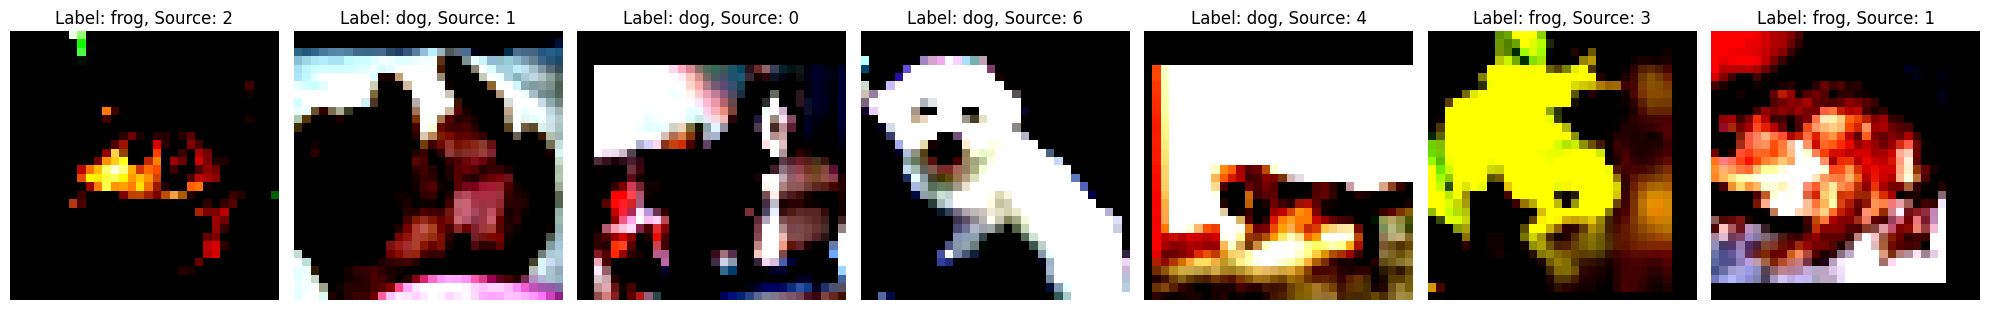

Split 2:


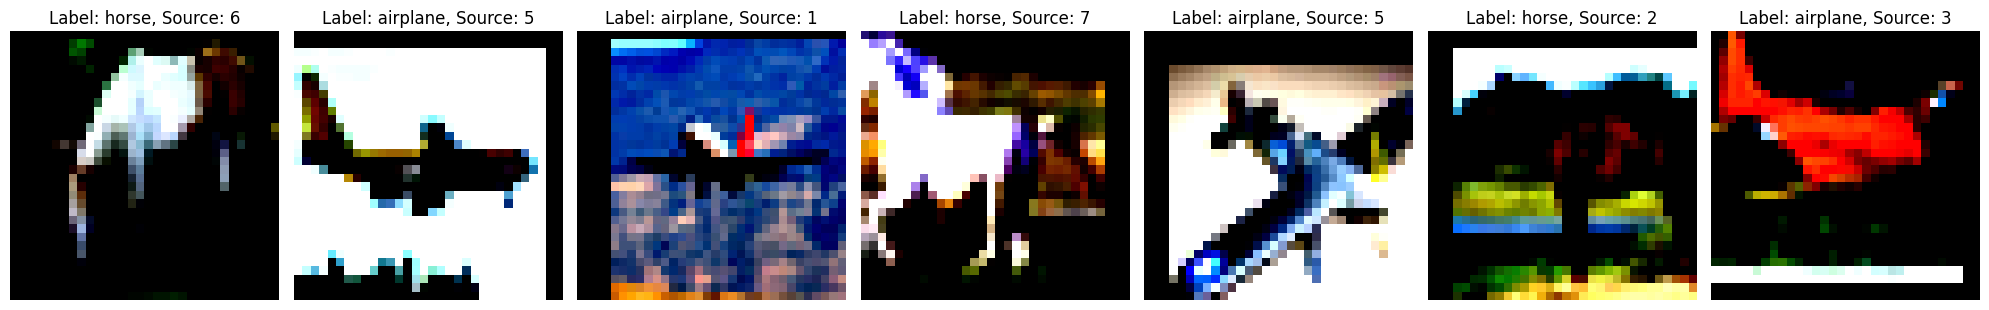

Split 3:


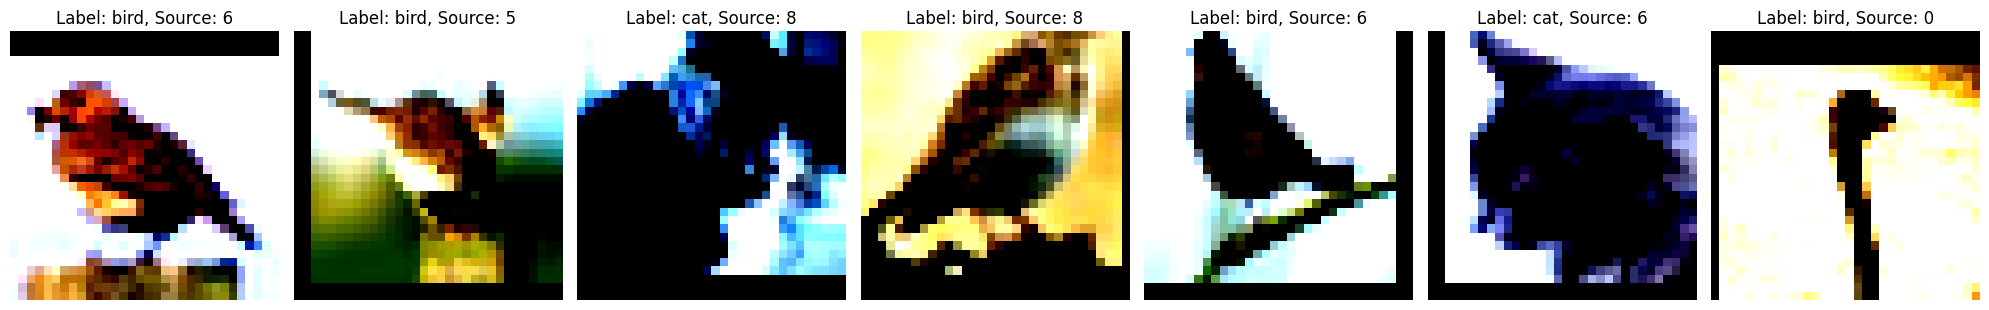

Split 4:


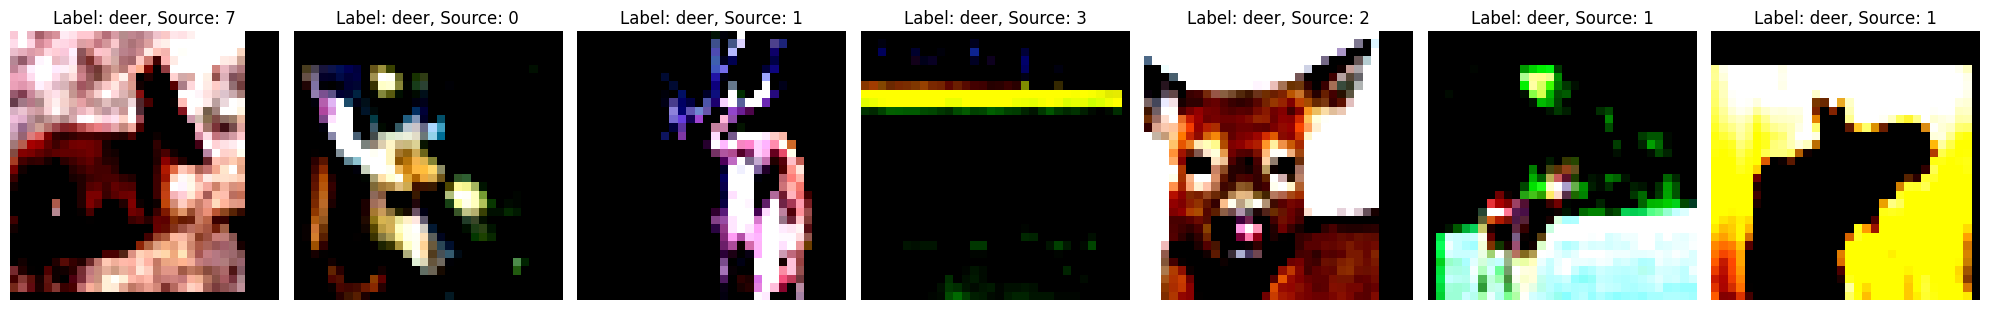

Split 5:


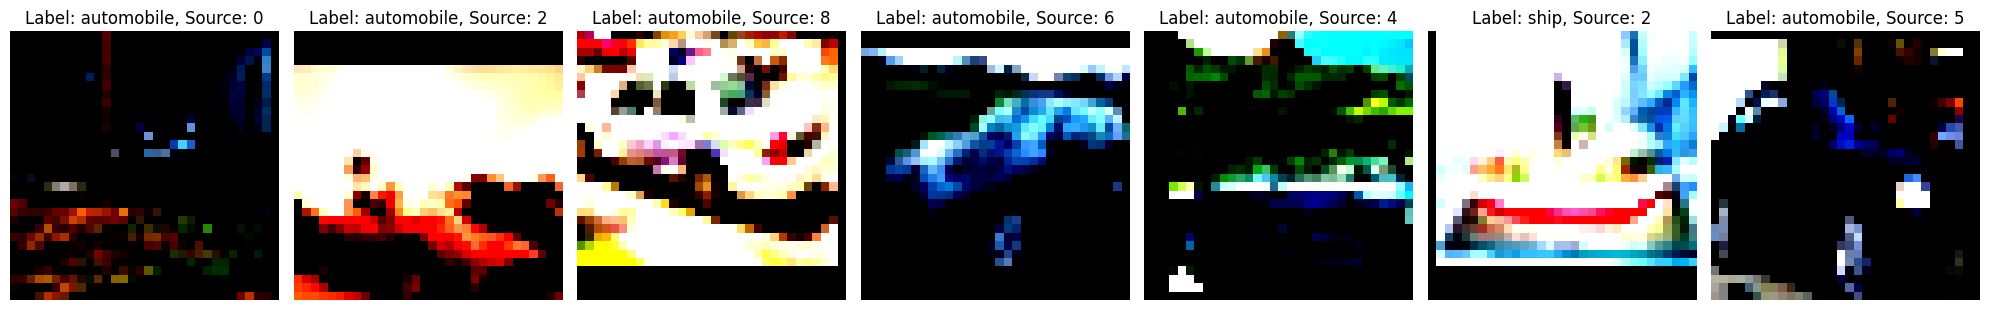

In [13]:
import matplotlib.pyplot as plt
import numpy as np

dataloaders = [torchdata.DataLoader(dataset, batch_size=10, shuffle=True) for dataset in train_dataset_subsets_class]

# CIFAR-10 class names
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Iterate over the splits
for split_idx, loader in enumerate(dataloaders):
    print(f"Split {split_idx + 1}:")
    
    # Calculate the number of rows and columns for subplots
    num_images = 7
    num_rows = 1
    num_cols = num_images
    
    # Create subplots with a row layout
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4))
    
    # Get the first batch from the DataLoader
    images, targets, sources = next(iter(loader))
    
    # Iterate over the images and targets
    for i in range(num_images):
        image = images[i]
        target = targets[i]
        source = sources[i]
        
        # Convert tensor to numpy array
        image = image.numpy()
        
        # Clip pixel values to the valid range [0, 1]
        image = np.clip(image, 0, 1)
        
        # Transpose image dimensions to match CIFAR format: (C, H, W)
        image = np.transpose(image, (1, 2, 0))
        
        # Display the image in the corresponding subplot
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {class_names[target]}, Source: {source.item()}")
        axes[i].axis('off')
    
    # Adjust the layout of subplots and display the plot
    plt.tight_layout()
    plt.show()

## Model

In [87]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),#0
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=0),#2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),#6
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),#8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(64, 64, kernel_size=1, padding=0),#12
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(1),
            nn.Dropout(p=0.25),
        )
        self.flatten = nn.Flatten()  # Add a flattening layer
        self.classifier = nn.Sequential(nn.Linear(64, num_classes))

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)  # Flatten the output of the convolutional layers
        x = self.classifier(x)
        return x

# Initialize the network, loss, and optimizer
neural_net = SimpleCNN()



network = nn.Sequential(neural_net)


#model.fc = nn.Linear(512, 10)  # Adjust the output layer for CIFAR-10

In [15]:
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm


class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, batch, task_id):
        """Saves a batch with its task ID."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (batch, task_id)
        self.position = (self.position + 1) % self.capacity

    def sample(self):
        return random.choice(self.memory)

    def __len__(self):
        return len(self.memory)

    def get_task_ids(self):
        return [task_id for _, task_id in self.memory]


def train(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs, replay_capacity=1000):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_loss_history = []  # Track training loss for each task
    val_loss_history = []  # Track validation loss for each task

    replay_memory = ExperienceReplay(replay_capacity)

    for split_idx, (train_dataloader, val_dataloader) in enumerate(zip(train_dataloaders, val_dataloaders)):
        print(f"Training on Split {split_idx + 1}:")
        model.train()  # Set the model to training mode

        task_train_loss = []  # Track training loss for the current task
        task_val_loss = []  # Track validation loss for the current task

        for epoch in range(num_epochs):
            batch_train_loss = 0.0
            correct = 0
            total = 0
            train_dataloader_and_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")

            for batch in train_dataloader_and_progress_bar:
                inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Store batch and task ID in replay memory
                replay_memory.push((inputs.detach(), targets.detach(), sources.detach()), split_idx)

                # Experience Replay
                if len(replay_memory) > 0:
                    replay_inputs, replay_targets, replay_sources = replay_memory.sample()[0]
                    replay_inputs, replay_targets, replay_sources = replay_inputs.to(device), replay_targets.to(device), replay_sources.to(device)

                    # Forward pass
                    replay_outputs = model(replay_inputs)
                    replay_loss = criterion(replay_outputs, replay_targets)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    replay_loss.backward()
                    optimizer.step()

                # Track statistics
                batch_train_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Update progress bar description
                train_dataloader_and_progress_bar.set_postfix(
                    loss=batch_train_loss / total, acc=100. * correct / total
                )

            # Save the training loss for the current task
            task_train_loss.append(batch_train_loss / total)

            # Validation
            model.eval()
            batch_val_loss = 0.0
            val_correct = 0
            val_total = 0
            val_dataloader_and_progress_bar = tqdm(val_dataloader, desc=f"Validation Epoch {epoch + 1}/{num_epochs}")

            with torch.no_grad():
                for batch in val_dataloader_and_progress_bar:
                    inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    batch_val_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()

                    # Update progress bar description
                    val_dataloader_and_progress_bar.set_postfix(
                        loss=batch_val_loss / val_total, acc=100. * val_correct / val_total
                    )

            # Save the validation loss for the current task
            task_val_loss.append(batch_val_loss / val_total)

        # Save the training and validation loss history for the current task
        train_loss_history.append(task_train_loss)
        val_loss_history.append(task_val_loss)

    task_ids = replay_memory.get_task_ids()

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.array([task_ids]), cmap='viridis', yticklabels=['Task IDs'], cbar=False)
    plt.title('Heatmap of Task IDs in Memory')
    plt.show()

    print('Finished Training')

In [16]:
## Test performance visualisation function
def test_performance(model, dataloader):
    model.eval()
    accuracies = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for task_id, test_dataloader in enumerate(dataloader):
        correct = 0
        total = 0

        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                inputs, labels = data[:2]
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Print first few predictions and labels in each batch
                #if i < 3:
                #    print(f"Batch {i+1} Predictions: {predicted[:5]}")
                #   print(f"Batch {i+1} Labels: {labels[:5]}")

        accuracy = correct / total * 100
        accuracies.append(accuracy)
        print(f"Accuracy on Test Task {task_id + 1}: {accuracy:.2f}%")

    return accuracies

## All model training

Training on Split 1:


Validation Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 169.65it/s, acc=87.4, loss=0.301]


Training on Split 2:


Validation Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 172.50it/s, acc=85.5, loss=0.382]


Training on Split 3:


Validation Epoch 20/20: 100%|██████████| 31/31 [00:00<00:00, 146.94it/s, acc=72.5, loss=0.734]


Training on Split 4:


Validation Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 164.47it/s, acc=85.8, loss=0.454]


Training on Split 5:


Validation Epoch 20/20: 100%|██████████| 31/31 [00:00<00:00, 172.76it/s, acc=89, loss=0.329]


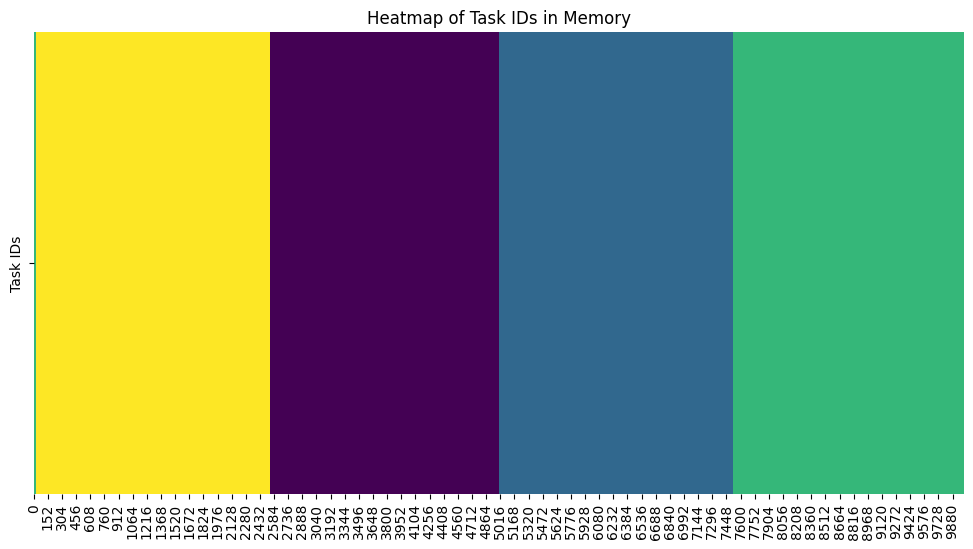

Finished Training


In [21]:
# Initialize the nmodel, criterion, optimizer
model = ImprovedCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Define the data loaders
train_dataloaders = [torchdata.DataLoader(train_ds, batch_size=64, shuffle=True) for train_ds in train_dataset_subsets_class]
val_dataloaders = [torchdata.DataLoader(val_ds, batch_size=64, shuffle=True) for val_ds in validation_dataset_subsets_class]
test_dataloaders = [torchdata.DataLoader(test_ds, batch_size=64, shuffle=True) for test_ds in test_dataset_subsets_class]

# Train the model
train(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs=20, replay_capacity=10000)

In [22]:
test_performance(model, test_dataloaders)

Accuracy on Test Task 1: 12.15%
Accuracy on Test Task 2: 62.15%
Accuracy on Test Task 3: 71.30%
Accuracy on Test Task 4: 62.35%
Accuracy on Test Task 5: 89.65%


[12.15, 62.150000000000006, 71.3, 62.35000000000001, 89.64999999999999]

Training on Split 1:


Validation Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 170.29it/s, acc=89.7, loss=0.247]


Training on Split 2:


Validation Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 168.29it/s, acc=79.9, loss=0.497]


Training on Split 3:


Validation Epoch 20/20: 100%|██████████| 31/31 [00:00<00:00, 172.86it/s, acc=75, loss=0.712]


Training on Split 4:


Validation Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 169.50it/s, acc=91, loss=0.314]


Training on Split 5:


Validation Epoch 20/20: 100%|██████████| 31/31 [00:00<00:00, 167.32it/s, acc=86.9, loss=0.405]


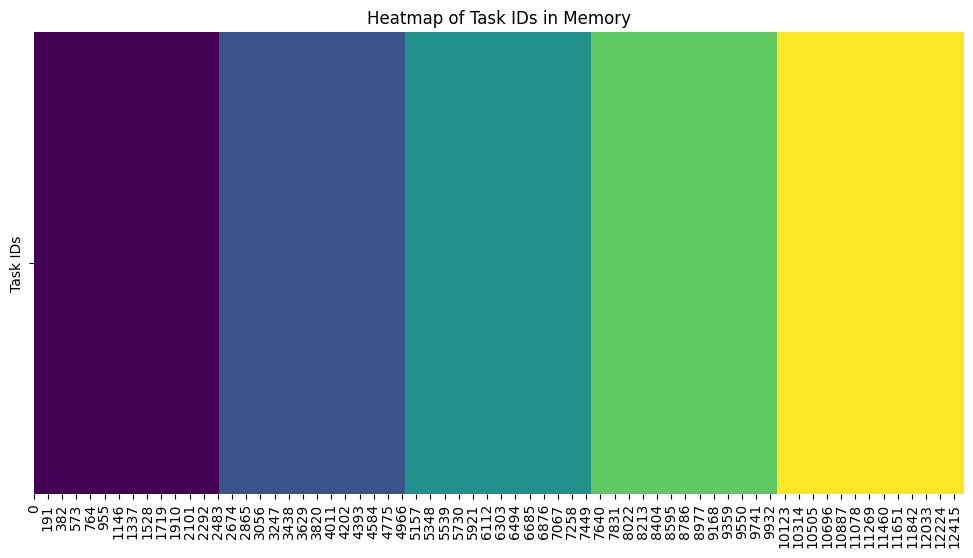

Finished Training


In [23]:
# Initialize the nmodel, criterion, optimizer
model = ImprovedCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Define the data loaders
train_dataloaders = [torchdata.DataLoader(train_ds, batch_size=64, shuffle=True) for train_ds in train_dataset_subsets_class]
val_dataloaders = [torchdata.DataLoader(val_ds, batch_size=64, shuffle=True) for val_ds in validation_dataset_subsets_class]
test_dataloaders = [torchdata.DataLoader(test_ds, batch_size=64, shuffle=True) for test_ds in test_dataset_subsets_class]

# Train the model
train(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs=20, replay_capacity=50000)

In [24]:
test_performance(model, test_dataloaders)

Accuracy on Test Task 1: 58.90%
Accuracy on Test Task 2: 50.45%
Accuracy on Test Task 3: 50.35%
Accuracy on Test Task 4: 71.10%
Accuracy on Test Task 5: 87.85%


[58.9, 50.449999999999996, 50.349999999999994, 71.1, 87.85]

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models

# Initialize the ResNet-50 model
resnet = models.resnet50(pretrained=False)

# Replace the last fully connected layer to match the number of classes in CIFAR-10 (10 classes)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 10)

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training on Split 1:


Validation Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 75.22it/s, acc=80.8, loss=0.906]


Training on Split 2:


Validation Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 60.02it/s, acc=76.5, loss=1.1]


Training on Split 3:


Validation Epoch 20/20: 100%|██████████| 31/31 [00:00<00:00, 70.26it/s, acc=48.2, loss=1.81]


Training on Split 4:


Validation Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 70.55it/s, acc=67.3, loss=1.27]


Training on Split 5:


Validation Epoch 20/20: 100%|██████████| 31/31 [00:00<00:00, 70.55it/s, acc=61.9, loss=1.39]


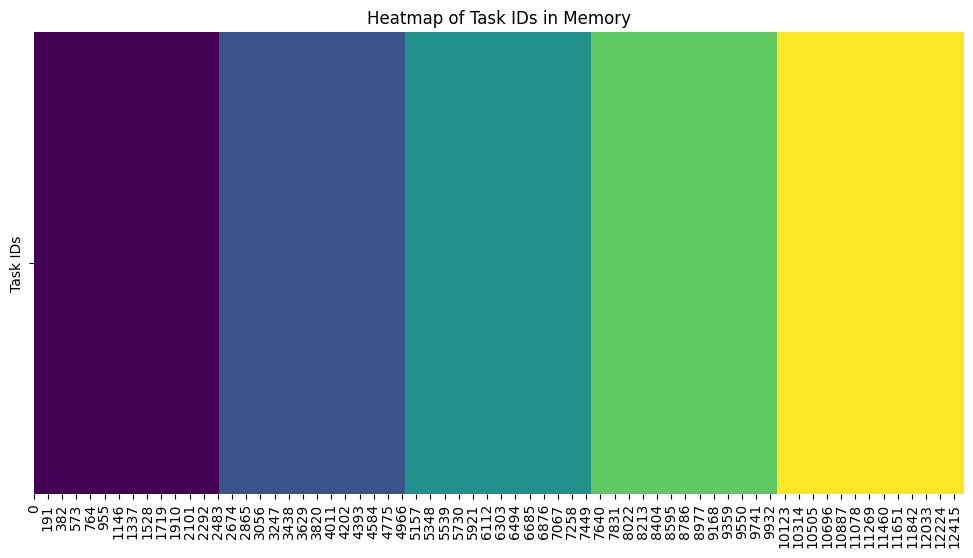

Finished Training


In [28]:
model = resnet

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Define the data loaders
train_dataloaders = [torchdata.DataLoader(train_ds, batch_size=64, shuffle=True) for train_ds in train_dataset_subsets_class]
val_dataloaders = [torchdata.DataLoader(val_ds, batch_size=64, shuffle=True) for val_ds in validation_dataset_subsets_class]
test_dataloaders = [torchdata.DataLoader(test_ds, batch_size=64, shuffle=True) for test_ds in test_dataset_subsets_class]

# Train the model
train(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs=20, replay_capacity=50000)

In [29]:
test_performance(model, test_dataloaders)

Accuracy on Test Task 1: 40.30%
Accuracy on Test Task 2: 33.10%
Accuracy on Test Task 3: 26.45%
Accuracy on Test Task 4: 53.60%
Accuracy on Test Task 5: 63.65%


[40.300000000000004, 33.1, 26.450000000000003, 53.6, 63.65]

In [31]:
import torch
import torch.nn as nn
import os

__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
]


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes=10,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group

        # CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False
        )
        # END

        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, device, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        script_dir = os.path.dirname(__file__)
        state_dict = torch.load(
            script_dir + "/state_dicts/" + arch + ".pt", map_location=device
        )
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, device, **kwargs
    )


def resnet34(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet34", BasicBlock, [3, 4, 6, 3], pretrained, progress, device, **kwargs
    )


def resnet50(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet50", Bottleneck, [3, 4, 6, 3], pretrained, progress, device, **kwargs
    )

In [107]:
## With LAP
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm


class ExperienceReplayLap():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, batch, task_id):
        """Saves a batch with its task ID."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (batch, task_id)
        self.position = (self.position + 1) % self.capacity

    def sample(self):
        return random.choice(self.memory)

    def __len__(self):
        return len(self.memory)

    def get_task_ids(self):
        return [task_id for _, task_id in self.memory]


def train_lap(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs, replay_capacity):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_loss_history = []  # Track training loss for each task
    val_loss_history = []  # Track validation loss for each task

    replay_memory = ExperienceReplayLap(replay_capacity)

    for split_idx, (train_dataloader, val_dataloader) in enumerate(zip(train_dataloaders, val_dataloaders)):
        print(f"Training on Split {split_idx + 1}:")
        model.train()  # Set the model to training mode

        task_train_loss = []  # Track training loss for the current task
        task_val_loss = []  # Track validation loss for the current task

        for epoch in range(num_epochs):
            batch_train_loss = 0.0
            correct = 0
            total = 0
            train_dataloader_and_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")

            for batch in train_dataloader_and_progress_bar:
                inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Store batch and task ID in replay memory
                replay_memory.push((inputs.detach(), targets.detach(), sources.detach()), split_idx)

                # Experience Replay
                if len(replay_memory) > 0:
                    replay_inputs, replay_targets, replay_sources = replay_memory.sample()[0]
                    replay_inputs, replay_targets, replay_sources = replay_inputs.to(device), replay_targets.to(device), replay_sources.to(device)

                    # Forward pass
                    replay_outputs = model(replay_inputs)
                    replay_loss = criterion(replay_outputs, replay_targets)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    replay_loss.backward()
                    optimizer.step()

                # Track statistics
                batch_train_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Update progress bar description
                train_dataloader_and_progress_bar.set_postfix(
                    loss=batch_train_loss / total, acc=100. * correct / total
                )

            # Save the training loss for the current task
            task_train_loss.append(batch_train_loss / total)

            # Validation
            model.eval()
            batch_val_loss = 0.0
            val_correct = 0
            val_total = 0
            val_dataloader_and_progress_bar = tqdm(val_dataloader, desc=f"Validation Epoch {epoch + 1}/{num_epochs}")

            with torch.no_grad():
                for batch in val_dataloader_and_progress_bar:
                    inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    batch_val_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()

                    # Update progress bar description
                    val_dataloader_and_progress_bar.set_postfix(
                        loss=batch_val_loss / val_total, acc=100. * val_correct / val_total
                    )

            # Save the validation loss for the current task
            task_val_loss.append(batch_val_loss / val_total)

        # Save the training and validation loss history for the current task
        train_loss_history.append(task_train_loss)
        val_loss_history.append(task_val_loss)

    task_ids = replay_memory.get_task_ids()

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.array([task_ids]), cmap='viridis', yticklabels=['Task IDs'], cbar=False)
    plt.title('Heatmap of Task IDs in Memory')
    plt.show()

    print('Finished Training')

Training on Split 1:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 109.41it/s, acc=86.7, loss=0.513]


Training on Split 2:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 108.78it/s, acc=87.7, loss=0.393]


Training on Split 3:


Validation Epoch 10/10: 100%|██████████| 31/31 [00:00<00:00, 107.27it/s, acc=56.8, loss=1.25]


Training on Split 4:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 105.88it/s, acc=77.1, loss=0.707]


Training on Split 5:


Validation Epoch 10/10: 100%|██████████| 31/31 [00:00<00:00, 105.95it/s, acc=85.9, loss=0.454]


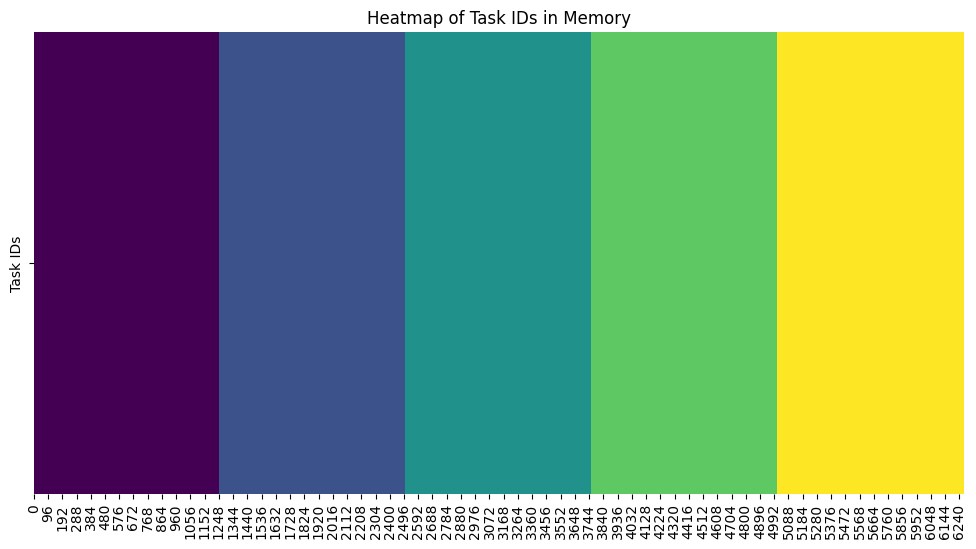

Finished Training


In [108]:
model = resnet18()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Define the data loaders
train_dataloaders = [torchdata.DataLoader(train_ds, batch_size=64, shuffle=True) for train_ds in train_dataset_subsets_class]
val_dataloaders = [torchdata.DataLoader(val_ds, batch_size=64, shuffle=True) for val_ds in validation_dataset_subsets_class]
test_dataloaders = [torchdata.DataLoader(test_ds, batch_size=64, shuffle=True) for test_ds in test_dataset_subsets_class]

# Train the model
train_lap(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs=10, replay_capacity=50000)

In [109]:
test_performance(model, test_dataloaders)

Accuracy on Test Task 1: 49.50%
Accuracy on Test Task 2: 45.70%
Accuracy on Test Task 3: 28.50%
Accuracy on Test Task 4: 54.10%
Accuracy on Test Task 5: 84.40%


[49.5, 45.7, 28.499999999999996, 54.1, 84.39999999999999]

Training on Split 1:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 111.74it/s, acc=87.6, loss=0.58]


Training on Split 2:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 104.39it/s, acc=89.2, loss=0.328]


Training on Split 3:


Validation Epoch 10/10: 100%|██████████| 31/31 [00:00<00:00, 106.89it/s, acc=63.6, loss=1]


Training on Split 4:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 107.49it/s, acc=75.3, loss=0.766]


Training on Split 5:


Validation Epoch 10/10: 100%|██████████| 31/31 [00:00<00:00, 106.88it/s, acc=82.8, loss=0.585]


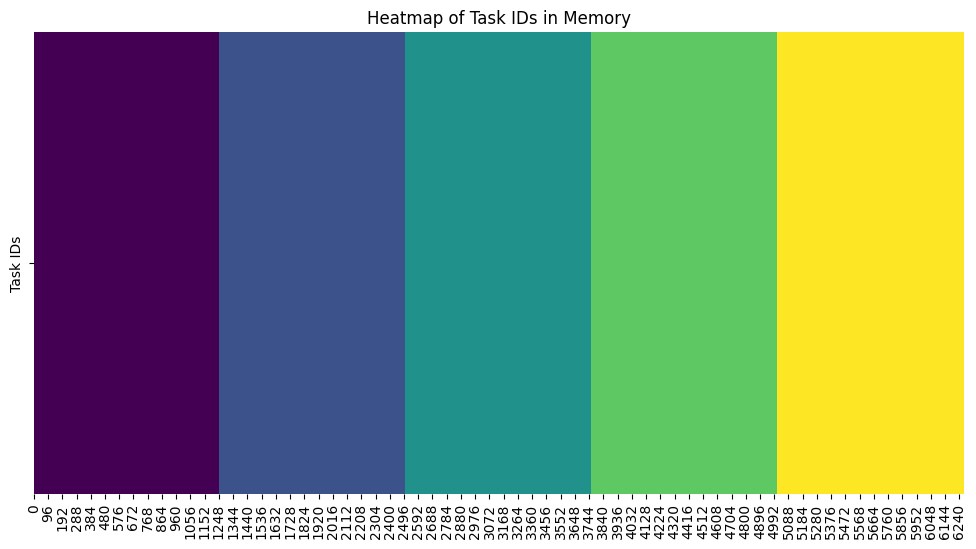

Finished Training


In [36]:
model = resnet18()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Define the data loaders
train_dataloaders = [torchdata.DataLoader(train_ds, batch_size=64, shuffle=True) for train_ds in train_dataset_subsets_class]
val_dataloaders = [torchdata.DataLoader(val_ds, batch_size=64, shuffle=True) for val_ds in validation_dataset_subsets_class]
test_dataloaders = [torchdata.DataLoader(test_ds, batch_size=64, shuffle=True) for test_ds in test_dataset_subsets_class]

# Train the model
train(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs=10, replay_capacity=50000)

In [38]:
test_performance(model, test_dataloaders)

Accuracy on Test Task 1: 54.90%
Accuracy on Test Task 2: 49.75%
Accuracy on Test Task 3: 30.35%
Accuracy on Test Task 4: 53.25%
Accuracy on Test Task 5: 83.20%


[54.900000000000006, 49.75, 30.349999999999998, 53.25, 83.2]

## With Loss Adapted Plasticity Optimiser

In [56]:
class ExperienceReplay_LAP():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, batch, task_id):
        """Saves a batch with its task ID."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (batch, task_id)
        self.position = (self.position + 1) % self.capacity

    def sample(self):
        return random.choice(self.memory)

    def __len__(self):
        return len(self.memory)

    def get_task_ids(self):
        return [task_id for _, task_id in self.memory]


def train_lap(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs, replay_capacity):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_loss_history = []  # Track training loss for each task
    val_loss_history = []  # Track validation loss for each task

    for split_idx, (train_dataloader, val_dataloader) in enumerate(zip(train_dataloaders, val_dataloaders)):
        print(f"Training on Split {split_idx + 1}:")
        model.train()  # Set the model to training mode

        task_train_loss = []  # Track training loss for the current task
        task_val_loss = []  # Track validation loss for the current task

        # Create separate replay memory for each split
        replay_memory = ExperienceReplay_LAP(replay_capacity)

        for epoch in range(num_epochs):
            batch_train_loss = 0.0
            correct = 0
            total = 0
            train_dataloader_and_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")

            for batch in train_dataloader_and_progress_bar:
                inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Store batch and task ID in replay memory
                replay_memory.push((inputs.detach(), targets.detach(), sources.detach()), split_idx)

                # Experience Replay
                if len(replay_memory) > 0:
                    replay_inputs, replay_targets, replay_sources = replay_memory.sample()[0]
                    replay_inputs, replay_targets, replay_sources = replay_inputs.to(device), replay_targets.to(device), replay_sources.to(device)

                    # Forward pass
                    replay_outputs = model(replay_inputs)
                    replay_loss = criterion(replay_outputs, replay_targets)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    replay_loss.backward()
                    optimizer.step()

                # Track statistics
                batch_train_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Update progress bar description
                train_dataloader_and_progress_bar.set_postfix(
                    loss=batch_train_loss / total, acc=100. * correct / total
                )

            # Save the training loss for the current task
            task_train_loss.append(batch_train_loss / total)

            # Validation
            model.eval()
            batch_val_loss = 0.0
            val_correct = 0
            val_total = 0
            val_dataloader_and_progress_bar = tqdm(val_dataloader, desc=f"Validation Epoch {epoch + 1}/{num_epochs}")

            with torch.no_grad():
                for batch in val_dataloader_and_progress_bar:
                    inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    batch_val_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()

                    # Update progress bar description
                    val_dataloader_and_progress_bar.set_postfix(
                        loss=batch_val_loss / val_total, acc=100. * val_correct / val_total
                    )

            # Save the validation loss for the current task
            task_val_loss.append(batch_val_loss / val_total)

        # Save the training and validation loss history for the current task
        train_loss_history.append(task_train_loss)
        val_loss_history.append(task_val_loss)

    task_ids = replay_memory.get_task_ids()

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.array([task_ids]), cmap='viridis', yticklabels=['Task IDs'], cbar=False)
    plt.title('Heatmap of Task IDs in Memory')
    plt.show()

    print('Finished Training')


Training on Split 1:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 46.07it/s, acc=84, loss=0.381]


Training on Split 2:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 44.94it/s, acc=91.4, loss=0.251]


Training on Split 3:


Validation Epoch 10/10: 100%|██████████| 31/31 [00:00<00:00, 46.65it/s, acc=75.6, loss=0.582]


Training on Split 4:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 46.36it/s, acc=92.8, loss=0.207]


Training on Split 5:


Validation Epoch 10/10: 100%|██████████| 31/31 [00:00<00:00, 44.67it/s, acc=92, loss=0.287]


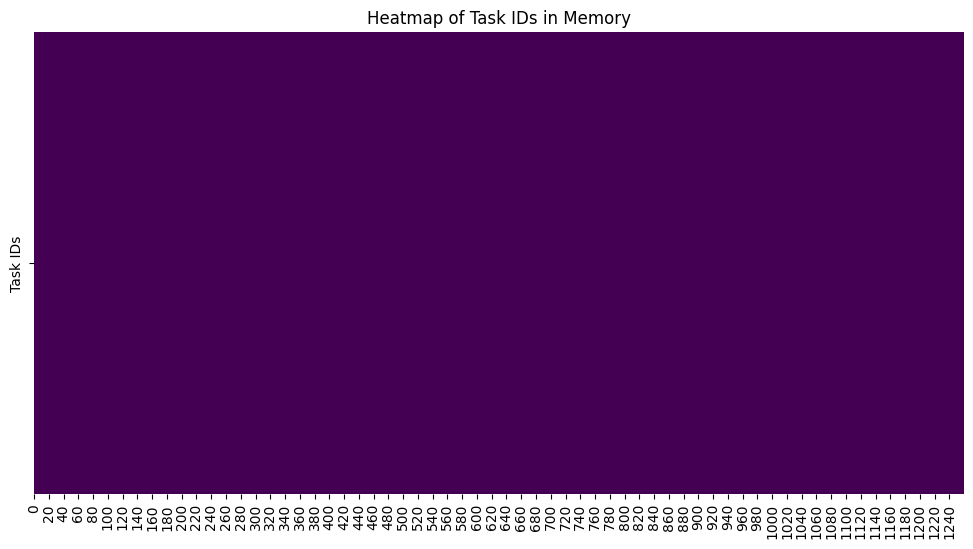

Finished Training


In [57]:
model = resnet18()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Define the data loaders
train_dataloaders = [torchdata.DataLoader(train_ds, batch_size=64, shuffle=True) for train_ds in train_dataset_subsets_class]
val_dataloaders = [torchdata.DataLoader(val_ds, batch_size=64, shuffle=True) for val_ds in validation_dataset_subsets_class]
test_dataloaders = [torchdata.DataLoader(test_ds, batch_size=64, shuffle=True) for test_ds in test_dataset_subsets_class]

# Train the model
train_lap(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs=10, replay_capacity=10000)

In [58]:
test_performance(model, test_dataloaders)

Accuracy on Test Task 1: 0.00%
Accuracy on Test Task 2: 0.00%
Accuracy on Test Task 3: 0.00%
Accuracy on Test Task 4: 0.00%
Accuracy on Test Task 5: 92.50%


[0.0, 0.0, 0.0, 0.0, 92.5]

In [75]:
import numpy as np

class ExperienceReplay_LAP():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, batch, task_id):
        """Saves a batch with its task ID."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (batch, task_id)
        self.position = (self.position + 1) % self.capacity

    def sample(self):
        return random.choice(self.memory)

    def __len__(self):
        return len(self.memory)

    def get_task_ids(self):
        return [task_id for _, task_id in self.memory]


import numpy as np
import matplotlib.pyplot as plt

def compute_loss_landscape(model, criterion, train_dataloader, weight_values, layer_index):
    loss_landscape = np.zeros((len(weight_values), len(weight_values)))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    layer = model.features[layer_index]
    weight_shape = layer.weight.shape  # Get the shape of the layer's weight tensor

    with torch.no_grad():
        for i, weight1 in enumerate(weight_values):
            for j, weight2 in enumerate(weight_values):
                # Create a new weight tensor with the desired shape
                new_weight = torch.zeros(weight_shape, device=device)
                new_weight[:, 0, :, :] = weight1
                new_weight[:, 1, :, :] = weight2
                layer.weight.data = new_weight

                total_loss = 0.0
                total_samples = 0

                for batch in train_dataloader:
                    inputs, targets, _ = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    total_loss += loss.item() * inputs.size(0)
                    total_samples += inputs.size(0)

                average_loss = total_loss / total_samples
                loss_landscape[i][j] = average_loss

    return loss_landscape


def plot_loss_landscape(loss_landscape, weight_values):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(weight_values, weight_values)

    ax.plot_surface(X, Y, loss_landscape, cmap='viridis')
    ax.set_xlabel('Weight 1')
    ax.set_ylabel('Weight 2')
    ax.set_zlabel('Loss')
    ax.set_title('Loss Landscape')

    plt.show()



def train_lap_with_loss_landscape(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs, replay_capacity, parameter1_values, parameter2_values):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_loss_history = []  # Track training loss for each task
    val_loss_history = []  # Track validation loss for each task

    for split_idx, (train_dataloader, val_dataloader) in enumerate(zip(train_dataloaders, val_dataloaders)):
        print(f"Training on Split {split_idx + 1}:")
        model.train()  # Set the model to training mode

        task_train_loss = []  # Track training loss for the current task
        task_val_loss = []  # Track validation loss for the current task

        # Create separate replay memory for each split
        replay_memory = ExperienceReplay_LAP(replay_capacity)

        for epoch in range(num_epochs):
            batch_train_loss = 0.0
            correct = 0
            total = 0
            train_dataloader_and_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")

            for batch in train_dataloader_and_progress_bar:
                inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Store batch and task ID in replay memory
                replay_memory.push((inputs.detach(), targets.detach(), sources.detach()), split_idx)

                # Experience Replay
                if len(replay_memory) > 0:
                    replay_inputs, replay_targets, replay_sources = replay_memory.sample()[0]
                    replay_inputs, replay_targets, replay_sources = replay_inputs.to(device), replay_targets.to(device), replay_sources.to(device)

                    # Forward pass
                    replay_outputs = model(replay_inputs)
                    replay_loss = criterion(replay_outputs, replay_targets)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    replay_loss.backward()
                    optimizer.step()

                # Track statistics
                batch_train_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Update progress bar description
                train_dataloader_and_progress_bar.set_postfix(
                    loss=batch_train_loss / total, acc=100. * correct / total
                )

            # Save the training loss for the current task
            task_train_loss.append(batch_train_loss / total)

            # Validation
            model.eval()
            batch_val_loss = 0.0
            val_correct = 0
            val_total = 0
            val_dataloader_and_progress_bar = tqdm(val_dataloader, desc=f"Validation Epoch {epoch + 1}/{num_epochs}")

            with torch.no_grad():
                for batch in val_dataloader_and_progress_bar:
                    inputs, targets, sources = batch[0].to(device), batch[1].to(device), batch[2].to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    batch_val_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()

                    # Update progress bar description
                    val_dataloader_and_progress_bar.set_postfix(
                        loss=batch_val_loss / val_total, acc=100. * val_correct / val_total
                    )

            # Save the validation loss for the current task
            task_val_loss.append(batch_val_loss / val_total)

        # Save the training and validation loss history for the current task
        train_loss_history.append(task_train_loss)
        val_loss_history.append(task_val_loss)

        # Compute the loss landscape
        loss_landscape = compute_loss_landscape(model, criterion, train_dataloader, parameter1_values, parameter2_values, replay_memory)

        # Plot the loss landscape
        plot_loss_landscape(loss_landscape, parameter1_values, parameter2_values, split_idx)

    task_ids = replay_memory.get_task_ids()

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.array([task_ids]), cmap='viridis', yticklabels=['Task IDs'], cbar=False)
    plt.title('Heatmap of Task IDs in Memory')
    plt.show()

    print('Finished Training')

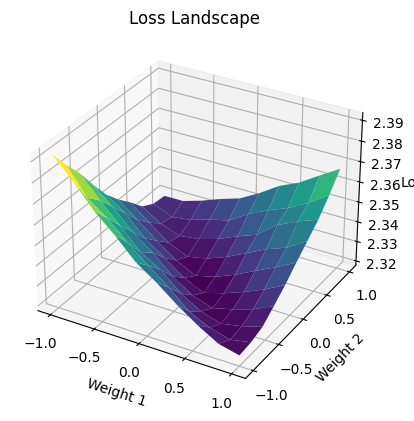

In [79]:
model = ImprovedCNN()  # Instantiate your model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Define the data loaders
train_dataloaders = [torchdata.DataLoader(train_ds, batch_size=64, shuffle=True) for train_ds in train_dataset_subsets_class]
val_dataloaders = [torchdata.DataLoader(val_ds, batch_size=64, shuffle=True) for val_ds in validation_dataset_subsets_class]
test_dataloaders = [torchdata.DataLoader(test_ds, batch_size=64, shuffle=True) for test_ds in test_dataset_subsets_class]



weight_values = np.linspace(-1, 1, 10)  # Specify the weight values to explore

layer_index = 0  # Replace with the desired layer index

train_dataloaders = train_dataloaders[layer_index]

# Train your model before computing the loss landscape
#train(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs=10)

# Compute the loss landscape
loss_landscape = compute_loss_landscape(model, criterion, train_dataloaders, weight_values, layer_index)

# Plot the loss landscape
plot_loss_landscape(loss_landscape, weight_values)

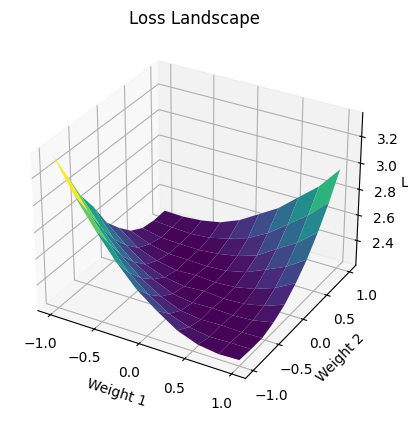

In [80]:
model = SimpleCNN(num_classes = 10)  # Instantiate your model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Define the data loaders
train_dataloaders = [torchdata.DataLoader(train_ds, batch_size=64, shuffle=True) for train_ds in train_dataset_subsets_class]
val_dataloaders = [torchdata.DataLoader(val_ds, batch_size=64, shuffle=True) for val_ds in validation_dataset_subsets_class]
test_dataloaders = [torchdata.DataLoader(test_ds, batch_size=64, shuffle=True) for test_ds in test_dataset_subsets_class]



weight_values = np.linspace(-1, 1, 10)  # Specify the weight values to explore

layer_index = 0  # Replace with the desired layer index

train_dataloaders = train_dataloaders[layer_index]

# Train your model before computing the loss landscape
#train(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs=10)

# Compute the loss landscape
loss_landscape = compute_loss_landscape(model, criterion, train_dataloaders, weight_values, layer_index)

# Plot the loss landscape
plot_loss_landscape(loss_landscape, weight_values)

In [106]:
import torch.nn.functional as F

model = SimpleCNN(num_classes=10)  # Instantiate your model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Define the data loaders
train_dataloaders = [torchdata.DataLoader(train_ds, batch_size=64, shuffle=True) for train_ds in train_dataset_subsets_class]
val_dataloaders = [torchdata.DataLoader(val_ds, batch_size=64, shuffle=True) for val_ds in validation_dataset_subsets_class]
test_dataloaders = [torchdata.DataLoader(test_ds, batch_size=64, shuffle=True) for test_ds in test_dataset_subsets_class]

weight_values = np.linspace(-1, 1, 10)  # Specify the weight values to explore

layer_index = 12  # Specify the desired layer index

train_dataloader = train_dataloaders[layer_index]

# Train your model before computing the loss landscape
# train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs=10)

# Replace the layer's weights with the weight values
original_weights = model.features[layer_index].weight.clone()
weight_shape = original_weights.shape
weight_values = torch.linspace(-1, 1, weight_shape[0] * weight_shape[1] * weight_shape[2] * weight_shape[3]).reshape(weight_shape)
model.features[layer_index].weight.data = weight_values

# Compute the loss landscape
loss_landscape = compute_loss_landscape(model, criterion, train_dataloader, weight_values, layer_index)

# Plot the loss landscape
plot_loss_landscape(loss_landscape, weight_values)

# Restore the original weights
model.features[layer_index].weight.data = original_weights.clone()

IndexError: ignored

In [39]:
from lap_wrapper import LAP

Training on Split 1:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 192.77it/s, acc=72.6, loss=0.546]


Training on Split 2:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 176.45it/s, acc=88.1, loss=0.455]


Training on Split 3:


Validation Epoch 10/10: 100%|██████████| 31/31 [00:00<00:00, 186.52it/s, acc=55.8, loss=1.21]


Training on Split 4:


Validation Epoch 10/10: 100%|██████████| 32/32 [00:00<00:00, 146.14it/s, acc=82.8, loss=0.679]


Training on Split 5:


Validation Epoch 10/10: 100%|██████████| 31/31 [00:00<00:00, 182.08it/s, acc=80.5, loss=0.681]


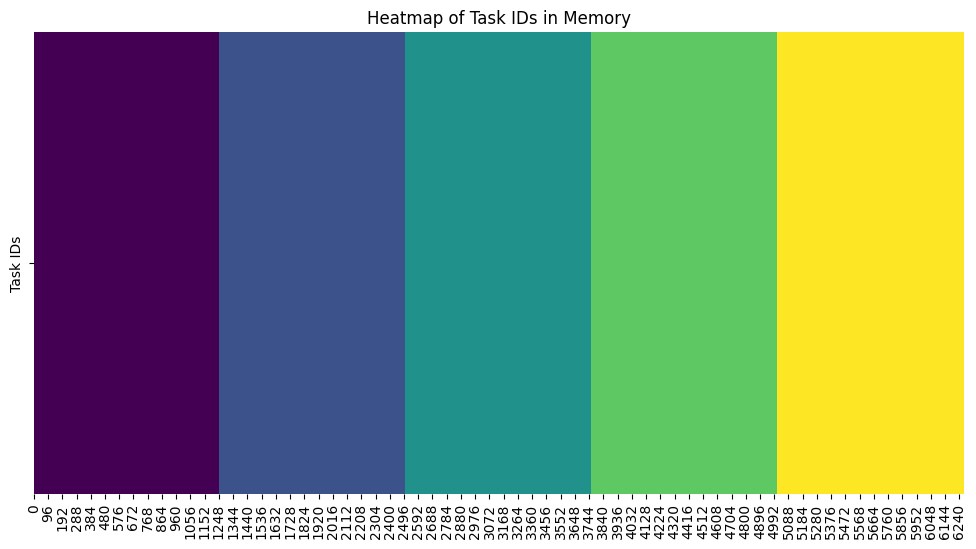

Finished Training


In [43]:
model = SimpleCNN(num_classes = 10)

criterion = nn.CrossEntropyLoss()
optimizer = LAP(torch.optim.SGD, params=model.parameters(), lr=0.01)

# Define the data loaders
train_dataloaders = [torchdata.DataLoader(train_ds, batch_size=64, shuffle=True) for train_ds in train_dataset_subsets_class]
val_dataloaders = [torchdata.DataLoader(val_ds, batch_size=64, shuffle=True) for val_ds in validation_dataset_subsets_class]
test_dataloaders = [torchdata.DataLoader(test_ds, batch_size=64, shuffle=True) for test_ds in test_dataset_subsets_class]

# Train the model
train_lap(model, criterion, optimizer, train_dataloaders, val_dataloaders, num_epochs=10, replay_capacity=50000)

In [44]:
test_performance(model, test_dataloaders)

Accuracy on Test Task 1: 68.60%
Accuracy on Test Task 2: 21.55%
Accuracy on Test Task 3: 16.35%
Accuracy on Test Task 4: 8.80%
Accuracy on Test Task 5: 80.40%


[68.60000000000001, 21.55, 16.35, 8.799999999999999, 80.4]